## Laboratorium 8.1


## Metody wykrywania ruchu: przepływ optyczny (_optical flow_)

### Wstęp

Na poprzednich laboratoriach poznaliśmy podstawowe metody przetwarzania obrazów, a więc dwuwymiarowych sygnałów przestrzennych. Wiele z tych metod działa także dla (trójwymiarowego) sygnału wideo, jeśli - nieco naiwnie - potraktujemy go jako po prostu sekwencję niezależnych obrazów.

W tej liście wykorzystasz także dziedziną czasową do przetwarzania sygnału. Podstawowa intuicja polega na tym, że jeśli jakiś rejon obrazu przesunął się w czasie, to prawdopodobnie ma on inne _znaczenie_ niż rejon, który pozostał w tym samym miejscu, lub przesunął w innym kierunku czy z inną szybkością. Jeśli zatem jesteśmy w stanie wykryć to przesunięcie - czyli po prostu _ruch_ - to otrzymamy pewną informację o zawartości obrazu (wideo). Na przykład, będziemy w stanie oddzielić poruszające się obiekty od stacjonarnego tła, albo oddzielić inaczej poruszające się obiekty.

Jedną z najpowszechniejszych metodą do automatycznej detekcji ruchu jest znana Ci już z wykładu metoda przepływu optycznego (ang. _optical flow_). Namawiam też do lektury [artykułu z dokumentacji OpenCV](https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html), zwłaszcza sekcji _Lucas-Kanade_ oraz _Dense Optical Flow_. Analizując kod metody, poświęć chwilę na zrozumienie mapowania wyników do prezentowanego obrazu w przestrzeni HSV.

Wiedzieć należy na pewno, że istnieją dwie główne odmiany metody przepływu optycznego:,
* przepływ gęsty (_dense_) - gdzie przesunięcie pomiędzy klatkami określane jest dla każdego piksela (na tej metodzie skupia się niniejsza część listy),
* przepływ rzadki (_sparse_) - gdzie ruch wykrywany jest tylko dla pewnego zbioru punktów zainteresowania w obrębie obrazu (przebadasz ją w drugiej części listy).

W ramach obu odmian występuje pewna liczba konkretnych metod obliczeniowych, w zależności od konkretnego podejścia do rozwiązywania równania ruchu. Na tych zajęciach wykorzystamy [algorytm Farnebacka](http://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf) - głównie dlatego, że jego gotowa implementacja znajduje się w pakiecie OpenCV.

### Podejście

Większość algorytmów optical flow operuje na parze klatek, znajdując wektory translacji pomiędzy rejonami z jednej i drugiej. Jeśli więc interesuje nas przetwarzanie ciągłego strumienia wideo, praca przebiegać będzie na zasadzie dwuelementowej kolejki, tzn. zawsze patrzymy na klatkę obecną $I(x,y,t)$ i poprzednią $I(x,y,t-1)$.

OpenCV oferuje banalnie prosty a zarazem potężny interfejs do obsługi strumieni wideo: [`cv2.VideoCapture`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html), za pomocą którego w ten sam sposób możemy obsługiwać pliki wideo w różnym kodowaniu, urządzenia wideo (np. kamerkę w laptopie) czy nawet wideo w protokole IP (choć występują pewne różnice z punktu widzenia użycia, jeśli korzystamy z zasobu sprzętowego działającego w czasie rzeczywistym). Idea jest prosta:
* tworzymy obiekt `cv2.VideoCapture` w odpowiedni sposób,
* pobieramy poszczególne klatki za pomocą metody [`VideoCapture::read`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html#a473055e77dd7faa4d26d686226b292c1).

Metoda `read` wykonuje całą pracę (odczytanie danych, dekodowanie strumienia wideo) i zwraca klatkę jako obraz w standardowym formacie OpenCV (a także flagę, czy w ogóle udało się pozyskać dane - krotka (flaga, klatka)). Zatem, aby pozyskać pierwszą klatkę z pliku wideo wystarczy:
```python
vid = cv2.VideoCapture("back.mp4")
r, frame = vid.read()
```

Drobnym ograniczeniem VideoCapture jest to, że nie ma możliwości cofnięcia się do poprzednio pobranej klatki (co jest naturalne w przypadku korzystania z fizycznego urządzenia do akwizycji, a może trochę mniej gdy czytamy z pliku). Jeśli potrzebny jest powrót do początku pliku wideo, niestety konieczne jest zamknięcie strumienia (`VideoCapture::release`) i ponowne otwarcie (`::open`).

Aby obliczyć (gęsty) przepływ optyczny pomiędzy dwiema klatkami, wykorzystamy algorytm Farnebacka, zaimplementowany w OpenCV w funkcji [`cv2.calcOpticalFlowFarneback`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af). Przyjmuje ona parę obrazów **w skali szarości**, opcjonalny argument `flow` (rozwiązanie można zainicjować poprzednio wyliczonym przepływem, jeśli nim dysponujemy), a następnie szereg parametrów sterujących metodą; m.in. można wykorzystać piramidyzację obrazów (rekomendowane `pyr_size` $=3$) czy określić rozmiar okna detekcji `winsize`. Sensowne pierwsze wartości dla argumentów podane są w dokumentacji.

Algorytm Farnebacka zwraca przepływ w formie obrazu o wymiarach przestrzennych równych obrazom wejściowym i dwóch kanałach, zawierających przesunięcie odpowiednio w osi $x$ i $y$. Można więc przetwarzać te dane dalej, np. obliczając kąt przesunięcia czy całkowitą odległość (i dalej, np. określić prędkość ruchu) - vide np. `cv2.cartToPolar`.

---

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Zadanie 1

#### Zadanie 1a
Otwórz wideo `kick.mp4` lub `back.mp4` i pobierz kilka klatek. Przewiń do interesującego Cię momentu - tak, aby uzyskać dwie klatki, na których widać ruch (pro-tip: znając framerate materiału (~25fps) i czas, w którym rozpoczyna się interesujący fragment, możesz w pętli "skonsumować" odpowiednią ilość klatek).  
Wykorzystaj algorytm Farnebacka do obliczenia przepływu pomiędzy klatkami. Wynik zaprezentuj w postaci obrazu całkowitego przesunięcia. W zależności od wybranego momentu w wideo, możesz spodziewać się uzyskania wyraźnych obszarów.

[h264 @ 0x55f73da80200] mmco: unref short failure
[h264 @ 0x55f73da80200] mmco: unref short failure


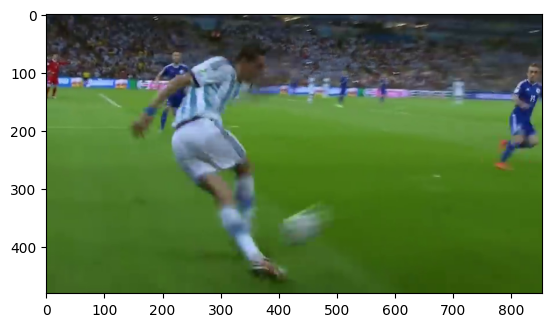

In [1]:
from utils import *

frames = extract_frames('back.mp4')
plt.imshow(frames[30])

In [17]:
farneback_params = {
"pyr_scale": 0.5,
"levels": 3,
"winsize": 5,
"iterations": 3,
"poly_n": 5,   
"poly_sigma": 1.2,
"flags": 0      
}

magnitude, angle = optical_flow(frames[30], frames[31], **farneback_params)

In [46]:
def rgb_circle(size = 500):
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    Theta = np.arctan2(Y, X)

    H = (Theta + np.pi) / (2 * np.pi)
    S = np.clip(R, 0, 1)
    V = np.ones_like(R)

    _ = np.stack((H, S, V), axis = -1)
    RGB = plt.cm.hsv(H)[:, :, :3]
    return RGB

In [ ]:
def plot_optical_flow(magnitude, angle, gap = 16):
    # vector field array
    x, y = np.meshgrid(np.arange(magnitude.shape[1]), np.arange(magnitude.shape[0]))
    u = magnitude * np.cos(angle)
    v = magnitude * np.sin(angle)
    x_gap = x[::gap, ::gap]
    y_gap = y[::gap, ::gap]
    u_gap = u[::gap, ::gap]
    v_gap = v[::gap, ::gap]
    angle_gap = angle[::gap, ::gap]
    # angle colors setup
    rgb_map = rgb_circle(size = magnitude.shape[0])
    hue_norm = ((angle_gap + np.pi) / (2 * np.pi) * (rgb_map.shape[1] - 1)).astype(int)
    hue_norm = np.clip(hue_norm, 0, rgb_map.shape[1] - 1)
    colors = rgb_map[0, hue_norm]

    plt.quiver(x_gap, y_gap, u_gap, v_gap, angles = 'xy', scale_units = 'xy', scale = 1, color = colors)
    # plt.imshow(frames[30])
    plt.show()


plot_optical_flow(magnitude, angle)

IndexError: index 551 is out of bounds for axis 1 with size 480

In [44]:
RGB.shape

(500, 500, 3)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


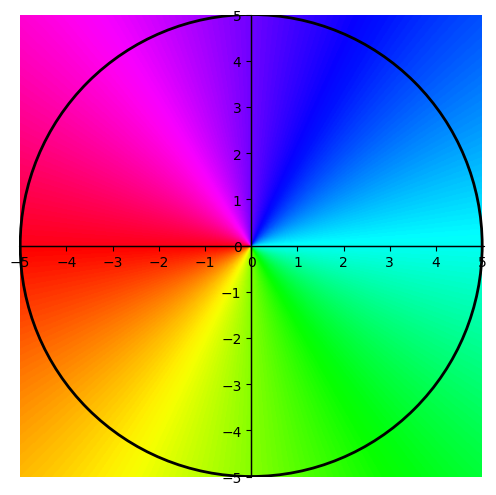

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Parametry obrazu
size = 500  # Rozmiar obrazu (piksele)
x = np.linspace(-1, 1, size)
y = np.linspace(-1, 1, size)
X, Y = np.meshgrid(x, y)

# Konwersja współrzędnych do przestrzeni biegunowej
R = np.sqrt(X**2 + Y**2)
Theta = np.arctan2(Y, X)

# Normalizacja wartości
H = (Theta + np.pi) / (2 * np.pi)  # Odcień (0-1)
S = np.clip(R, 0, 1)               # Nasycenie (0-1)
V = np.ones_like(R)                # Jasność (1)

# Konwersja HSV -> RGB
HSV = np.stack((H, S, V), axis=-1)
RGB = plt.cm.hsv(H)[:, :, :3]  # Zamień HSV na RGB

# Rysowanie wykresu
plt.figure(figsize=(6, 6))
plt.imshow(RGB, extent=(-5, 5, -5, 5), origin='lower')

# Dodanie okręgu
circle = plt.Circle((0, 0), 5, color='black', fill=False, lw=2)
plt.gca().add_artist(circle)

# Wyśrodkowanie osi
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)

# Konfiguracja osi
plt.axis('equal')
plt.axis([-5, 5, -5, 5])
plt.xticks(np.arange(-5, 6, 1))
plt.yticks(np.arange(-5, 6, 1))
plt.gca().spines['left'].set_position('center')
plt.gca().spines['bottom'].set_position('center')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

# Usunięcie niepotrzebnych znaczników
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().yaxis.set_ticks_position('left')
plt.show()


In [ ]:
def draw_optical_flow(flow, step=16):
    h, w = flow.shape[:2]
    y, x = np.mgrid[step//2:h:step, step//2:w:step].astype(int)
    fx, fy = flow[y, x, 0], flow[y, x, 1]  # Ekstrakcja x i y przepływu

    lines = np.vstack([x.ravel(), y.ravel(), x.ravel() + fx.ravel(), y.ravel() + fy.ravel()]).T.reshape(-1, 2, 2)
    lines = np.int32(lines)

    vis = np.zeros((h, w, 3), dtype=np.uint8)
    for (x1, y1), (x2, y2) in lines:
        cv2.arrowedLine(vis, (x1, y1), (x2, y2), (0, 255, 0), 1, tipLength=0.3)

    return vis

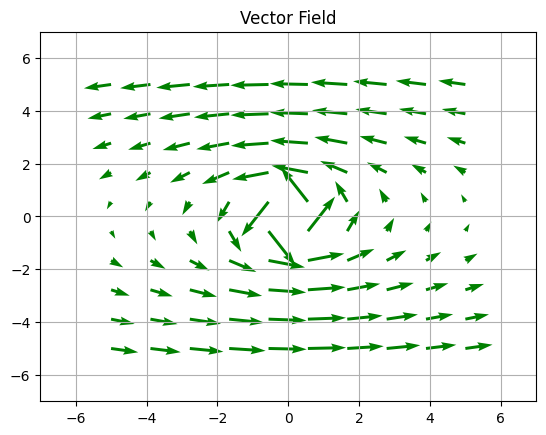

In [23]:
import numpy as np 
import matplotlib.pyplot as plt 
  
# Meshgrid 
x, y = np.meshgrid(np.linspace(-5, 5, 10),  
                   np.linspace(-5, 5, 10)) 
  
# Directional vectors 
u = -y/np.sqrt(x**2 + y**2) 
v = x/(x**2 + y**2) 
  
# Plotting Vector Field with QUIVER 
plt.quiver(x, y, u, v, color='g') 
plt.title('Vector Field') 
  
# Setting x, y boundary limits 
plt.xlim(-7, 7) 
plt.ylim(-7, 7) 
  
# Show plot with grid 
plt.grid() 
plt.show()

In [24]:
def plot_optical_flow(flow):
    _, axs = plt.subplots(1, 1, figsize = (10, 5))
    axs.imshow(flow, cmap = 'gray')
    plt.show()


#### Zadanie 1b
Zbadaj wpływ parametru `winsize` na działanie metody.

In [34]:
farneback_params_1b = {
"pyr_scale": 0.5,
"levels": 3,
"winsize": 15,
"iterations": 3,
"poly_n": 5,   
"poly_sigma": 1.2,
"flags": 0      
}

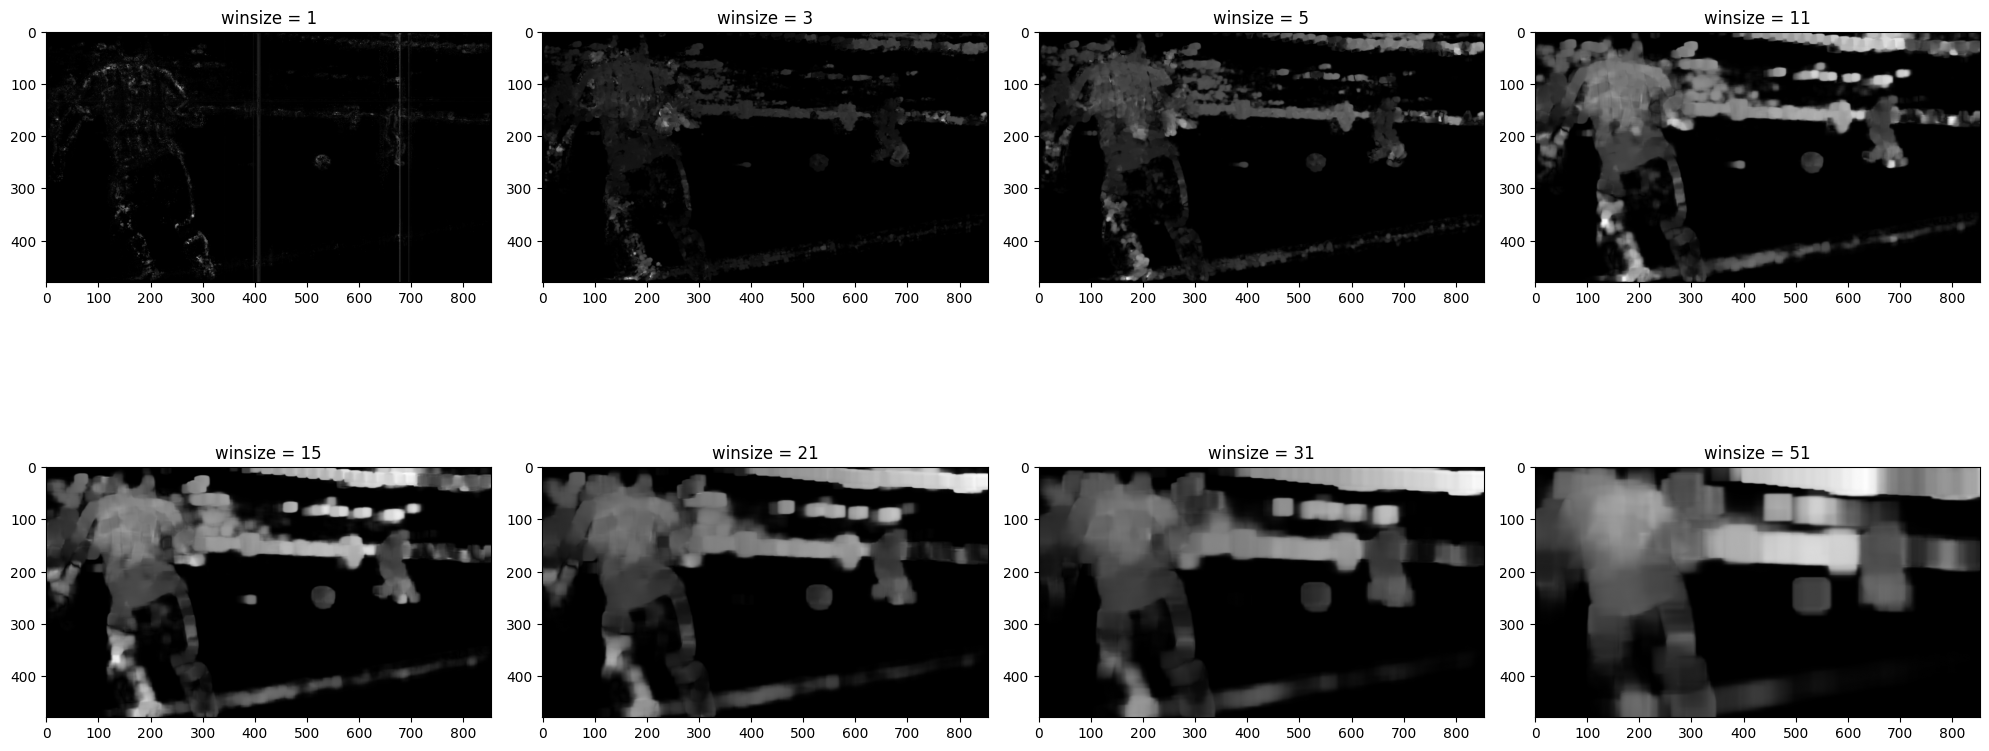

In [42]:
winsizes = [1, 3, 5, 11, 15, 21, 31, 51]
_, axs = plt.subplots(2, 4, figsize = (20, 10))
for i, winsize in enumerate(winsizes):
    farneback_params_1b['winsize'] = winsize
    flow = count_optical_flow(frames[40], frames[41], show = False, **farneback_params_1b)
    axs[i // 4, i % 4].imshow(flow, cmap = 'gray')
    axs[i // 4, i % 4].set_title(f'winsize = {winsize}')
plt.tight_layout()
plt.show()

Komentarz 1:

...

---

### Zadanie 2

Powtórz powyższy eksperyment na materiale `shot.mp4` (przewiń materiał do momentu natychmiast po uderzeniu białej bili, ok. 20-25 klatek; framerate wynosi tu ok. 15fps).  
*Czy algorytm działa tak samo dobrze? Dlaczego? Co jest ograniczeniem metody?*

In [67]:
frames_2 = extract_imgs_from_vid('shot.mp4', 1)

In [68]:
farneback_params_2 = {
"pyr_scale": 0.5,
"levels": 3,
"winsize": 15,
"iterations": 3,
"poly_n": 5,   
"poly_sigma": 1.2,
"flags": 0      
}

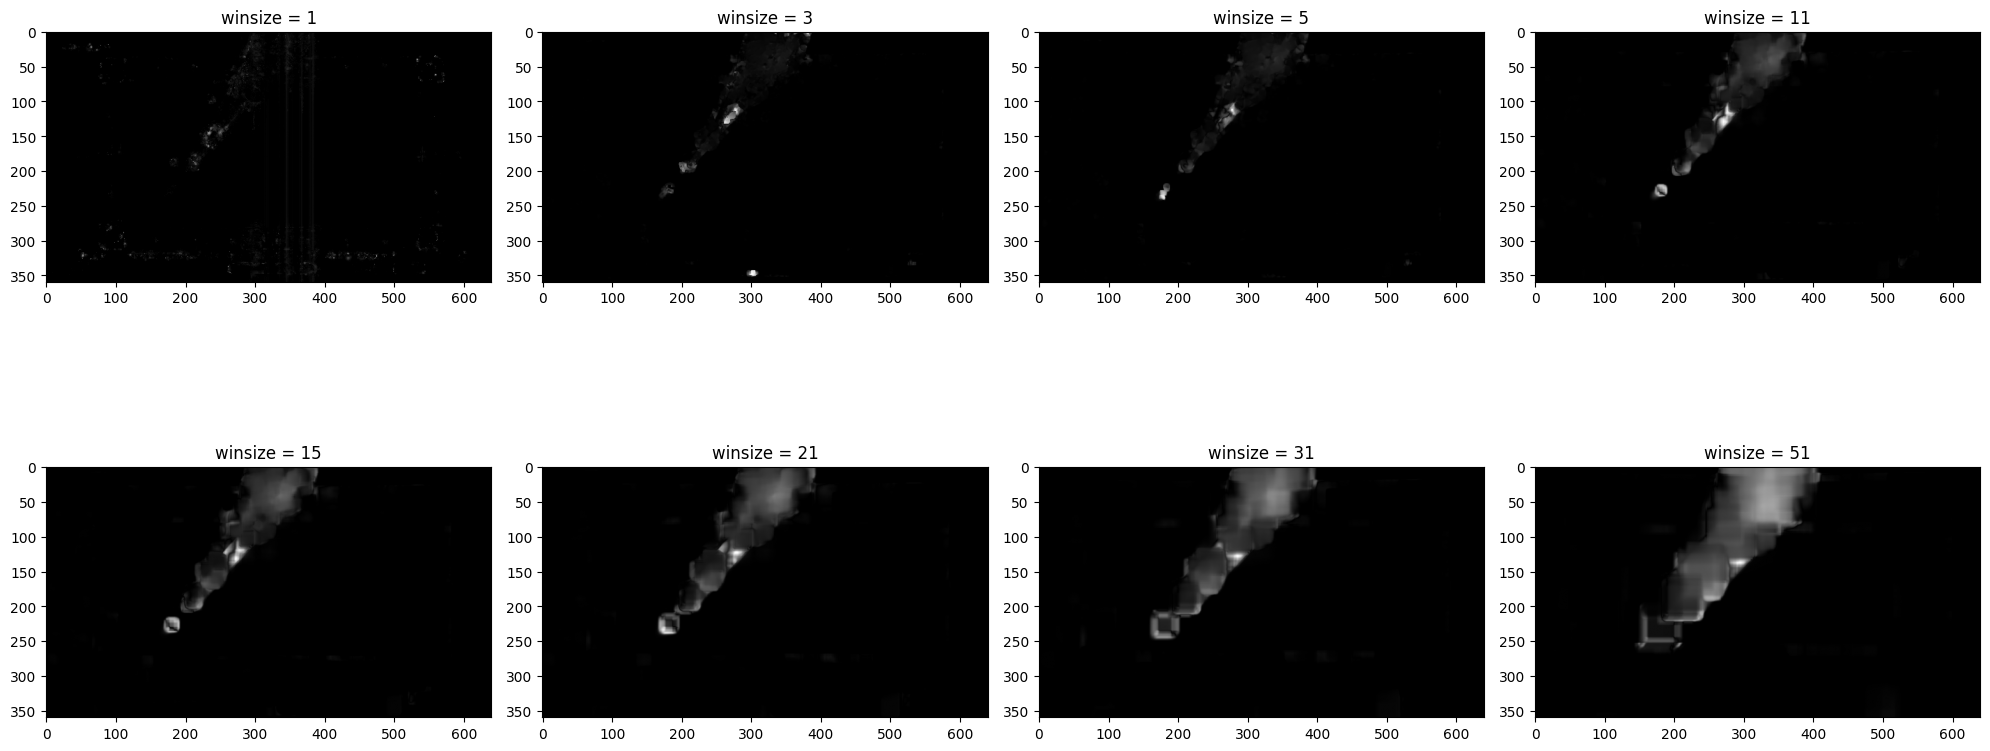

In [70]:
n = 20

winsizes = [1, 3, 5, 11, 15, 21, 31, 51]
_, axs = plt.subplots(2, 4, figsize = (20, 10))
for i, winsize in enumerate(winsizes):
    farneback_params_2['winsize'] = winsize
    flow = count_optical_flow(frames_2[n], frames_2[n + 1], show = False, **farneback_params_2)
    axs[i // 4, i % 4].imshow(flow, cmap = 'gray')
    axs[i // 4, i % 4].set_title(f'winsize = {winsize}')
plt.tight_layout()
plt.show()

Komentarz 2:

...

### Zadanie dla chętnych

Powróć do takiego przypadku i konfiguracji algorytmu, dla którego uzyskane przez Ciebie wyniki były satysfakcjonujące. Przypomnij sobie zajęcia dotyczące np. segmentacji i wykorzystaj informację o przepływie optycznym do oddzielenia na obrazie obiektów od tła (metoda zupełnie dowolna).